In [1]:
# 경고(warning) 비표시
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# 제4장 고객의 행동을 예측하는 테크닉 10

### 테크닉 31 : 데이터를 읽어들이고 확인하자

In [2]:
use_log = pd.read_csv('use_log.csv')
use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### 테크닉 32 : 클러스터링으로 회원을 그룹화하자

In [4]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# 데이터를 표준화하는 것을 말함
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [6]:
pd.DataFrame(customer_clustering_sc)

,0,1,2,3,4
0,-0.281206,-0.133676,0.081177,-0.533620,2.034025
1,-0.140545,-0.133676,-0.379928,-0.021149,2.034025
2,-0.421867,-0.133676,-0.841034,-0.021149,2.034025
3,-0.281206,-0.400393,-0.379928,-0.533620,2.034025
4,-0.796964,-0.667109,-0.841034,-1.046090,2.034025
...,...,...,...,...,...
4187,1.500501,1.466622,0.081177,2.541203,-1.288115
4188,2.625790,2.533488,1.003389,3.566144,-1.288115
4189,1.500501,1.466622,0.081177,2.541203,-1.288115
4190,3.188435,3.066921,1.464494,4.078615,-1.288115


In [7]:
# customer_clustering_sc데이터를 넣어 클러스터링
# kmeans 모델을 정의한다.
kmeans = KMeans(n_clusters=4, random_state=0)
# 클러스터링 모델을 구축한다.
clusters = kmeans.fit(customer_clustering_sc)

In [8]:
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"])

0       1
1       1
2       1
3       1
4       1
       ..
4187    0
4188    0
4189    0
4190    0
4191    0
Name: cluster, Length: 4192, dtype: int32


In [9]:
customer_clustering.rename(columns={'mean':'월평균값', 'median':'월중앙값', 'max':'월최댓값', 'min':'월최솟값', 'membership_period':'회원기간'}, inplace=True)
customer_clustering

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1
...,...,...,...,...,...,...
4187,8.000000,8.0,8,8,1,0
4188,10.000000,10.0,10,10,1,0
4189,8.000000,8.0,8,8,1,0
4190,11.000000,11.0,11,11,1,0


### 테크닉 33 : 클러스터링 결과를 분석하자

In [10]:
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [11]:
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


### 테크닉 34 : 클러스터링 결과를 가시화하자

In [12]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)

In [13]:
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering['cluster']

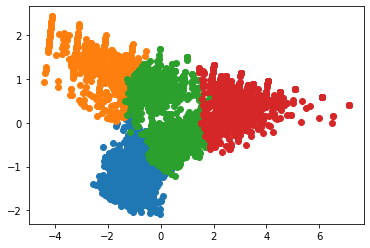

In [14]:
import matplotlib.pyplot as plt

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])

### 테크닉 35 : 클러스터링 결과를 바탕으로 탈퇴회원의 경향을 파악하자

In [15]:
customer_clustering.head()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [16]:
x = pd.concat([customer,customer_clustering] , axis=1)
x.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [17]:
x.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster','routine_flg','customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


### 테크닉 36 : 다음달의 이용횟수 예측을 위해 테이터를 준비하자

In [18]:
use_log["usedate"] = pd.to_datetime(use_log["usedate"])
use_log["연월"] = use_log["usedate"].dt.strftime("%Y%m")

In [19]:
use_log.head()

,log_id,customer_id,usedate,연월
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [20]:
use_log_month = use_log.groupby(['연월', 'customer_id'], as_index=False).count()[['연월','customer_id''log_id']]
use_log_month.head()

,연월,customer_id,log_id
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [40]:
year_month = list(use_log['연월'].unique())
print(year_month)
predict_data = pd.DataFrame()

for i in range(6, len(year_month)):
    tmp = use_log_month.loc[use_log_month['연월'] == year_month[i]]
    print(tmp)
    tmp.rename(columns={'log_id':'count_pred'}, inplace=True)
    for j in range(1,7):
        tmp_before = use_log_month.loc[use_log_month['연월'] == year_month[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={'log_id':'log_id_{}'.format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on = "customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)


['201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903']
           연월 customer_id  log_id
18532  201810    AS002855       3
18533  201810    AS008805       2
18534  201810    AS009373       5
18535  201810    AS015233       7
18536  201810    AS015315       4
...       ...         ...     ...
21597  201810    TS995299       4
21598  201810    TS998593       9
21599  201810    TS999079       6
21600  201810    TS999231       5
21601  201810    TS999855       4

[3070 rows x 3 columns]
           연월 customer_id  log_id
21602  201811    AS002855       5
21603  201811    AS008805       3
21604  201811    AS009373       4
21605  201811    AS015233       7
21606  201811    AS015315       7
...       ...         ...     ...
24642  201811    TS995299       5
24643  201811    TS998593       9
24644  201811    TS999079       6
24645  201811    TS999231       5
24646  201811    TS999855       4

[3045 rows x 3 columns]
           연월

In [41]:
predict_data['연월'].unique()

array(['201810', '201811', '201812', '201901', '201902', '201903'],
      dtype=object)

In [42]:
predict_data=predict_data.dropna()

In [43]:
predict_data=predict_data.reset_index(drop=True)

In [44]:
predict_data[predict_data['customer_id']=='AS015315']

,연월,customer_id,count_pred,log_id_0,log_id_1,log_id_2,log_id_3,log_id_4,log_id_5
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
2426,201811,AS015315,7,4.0,7.0,3.0,6.0,3.0,3.0
4936,201812,AS015315,5,7.0,4.0,7.0,3.0,6.0,3.0
7504,201901,AS015315,5,5.0,7.0,4.0,7.0,3.0,6.0
10082,201902,AS015315,5,5.0,5.0,7.0,4.0,7.0,3.0
12629,201903,AS015315,4,5.0,5.0,5.0,7.0,4.0,7.0


### 테크닉 37 : 특징이 되는 변수를 추가하자

In [45]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on="customer_id", how="left")
predict_data

,연월,customer_id,count_pred,log_id_0,log_id_1,log_id_2,log_id_3,log_id_4,log_id_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01
...,...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0,2015-09-01
15109,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0,2018-09-01
15110,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0,2016-06-01
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01


In [47]:
predict_data["now_date"] = pd.to_datetime(predict_data['연월'],format='%Y%m')
predict_data["start_date"] = pd.to_datetime(predict_data['start_date'])

In [48]:
from dateutil.relativedelta import relativedelta
predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years*12 + delta.months

predict_data.head()

,연월,customer_id,count_pred,log_id_0,log_id_1,log_id_2,log_id_3,log_id_4,log_id_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### 테크닉 38 : 다음달 이용횟수를 예측하는 모델을 구축하자

In [49]:
predict_data = predict_data.loc[predict_data['start_date']>=pd.to_datetime("20180401")]

In [50]:
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()

In [51]:
X = predict_data[["log_id_0","log_id_1","log_id_2","log_id_3","log_id_4","log_id_5","period" ]]

In [52]:
y = predict_data['count_pred']

In [62]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [63]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6051575016156108
0.6121206433441384


### 테크닉 39 : 모델에 기여하는 변수를 확인하자

In [64]:
coef = pd.DataFrame({'feature_names':X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,log_id_0,0.349606
1,log_id_1,0.192170
2,log_id_2,0.170723
3,log_id_3,0.150906
4,log_id_4,0.077198
5,log_id_5,0.068850
6,period,0.098436


### 테크닉 40 : 다음달의 이용횟수를 예측하자

In [65]:
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1, x2]

In [69]:
model.predict(x_pred)

array([3.78334503, 2.0483166 ])